<a href="https://colab.research.google.com/github/yajuna/tensorflow_pde/blob/master/Heat_equation_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook solves the polar heat equation in one dimension

$\rho c \frac{\partial T}{\partial t}=\frac{\partial k}{\partial r}\frac{\partial T}{\partial r}+\frac{k}{r}\frac{\partial T}{\partial r}+k\frac{\partial^2 T}{\partial r^2}+\text{source terms}$

With the assumption that $\frac{\partial k}{\partial r} = 0$, the equation simplifies to

$\rho c \frac{\partial T}{\partial t}=\frac{k}{r}\frac{\partial T}{\partial r}+k\frac{\partial^2 T}{\partial r^2}+\text{source terms}$

The initial condition is linearly interpolated from the measured core and bark temperatures at $t = 0$. Two boundary conditions are from the measured core and bark temperatures.

We aim to solve the inverse problem for determining the parameters in the original continuous PDE.

The inverse problem is formulated to be

$\frac{\partial T}{\partial t}=\lambda_1\frac{1}{r}\frac{\partial T}{\partial r}+\lambda_1\frac{\partial^2 T}{\partial r^2}+\lambda_2\text{ source term}$

and the Physics information is

$\text{residual} = \frac{\partial T}{\partial t}-\lambda_1\frac{1}{r}\frac{\partial T}{\partial r}-\lambda_1\frac{\partial^2 T}{\partial r^2}-\lambda_2\text{ source term}$

The source term is isolated, as it is not a time independent tree property we identify.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas

from time import time

from IPython.display import clear_output



clear_output()

Set hyperparameters

In [2]:
# set data type and hyperparameters
# import data

DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

EPOCH = 6000

# Set number of data points
N_0 = 411 # number of points in space; this is the amount of measurements in 24 hours
N_b = 411 # number of points in time; same as N_0 for simplicity
N_r = 1000

# Set boundary
tmin = 0.
tmax = 24.
xmin = 0.00#0.001
xmax = 0.135

# heat parameters
sigma = 5.76e-8
albedo = 0.3

# Lower bounds in time and space
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds in time and space
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data; need N_0 == N_b for concat
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_init = tf.linspace(lb[1], ub[1], N_0)
x_0 = tf.reshape(x_init, (N_0,1))
X_0 = tf.concat([t_0, x_0], axis=1)

# Boundary data- we compare left and right boundary at give time steps.
t_boundary = tf.linspace(lb[0], ub[0], N_b)
t_b = tf.reshape(t_boundary, (N_b,1))
x_lb = tf.ones((N_b,1), dtype=DTYPE)*lb[1]
x_ub = tf.ones((N_b,1), dtype=DTYPE)*ub[1]
X_lb = tf.concat([t_b, x_lb], axis=1)
X_ub = tf.concat([t_b, x_ub], axis=1)


# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

In [3]:
##### measured tree temperature for initial and boundary conditions. Need fixing
colnames_tree_temp = ['datetime', 's45_1', 'e9_1', 'n135_1','e45_2', 'n9_2', 'w135_2', 'n45_3', 'w9_3','s135_3', 'w_ext_35']
url1 = "https://raw.githubusercontent.com/yajuna/linearRegression/master/Tree_Temp_Values_AUG21_to_AUG28_2022.xlsx"
dataTemp = pandas.read_excel(url1,names=colnames_tree_temp)

##### ave tree temp and weather temp for future reference
train_tree_temp_index = 416 - 2

train_interp_temp_size = train_tree_temp_index
test_tree_temp_index = 827 - 2
train_interp_temp_size = train_tree_temp_index
test_interp_temp_size = test_tree_temp_index - train_tree_temp_index

train_weather_index = 145 - 2
test_weather_index = 289 -2
train_interp_weather_size = train_weather_index
test_interp_weather_size = test_weather_index - train_weather_index
####

### Initial and boundary conditions
# core temp is west, at 13.5cm, at 2m high
test_coreTemp = np.array(dataTemp.s135_3[train_tree_temp_index: test_tree_temp_index])+ 273.15
# West, at 9cm, at 3m high
test_midTemp1 = np.array(dataTemp.w9_3[train_tree_temp_index: test_tree_temp_index])+ 273.15
# North, at 4.5cm, at 3m high
test_midTemp2 = np.array(dataTemp.n45_3[train_tree_temp_index: test_tree_temp_index])+ 273.15
# bark temp is West, at bark, at 3.5m high
test_barkTemp = np.array(dataTemp.w_ext_35[train_tree_temp_index: test_tree_temp_index])+ 273.15

initTemp = np.array([test_coreTemp[0], test_midTemp1[0], test_midTemp2[0], test_barkTemp[0]])
init_temp = np.interp(np.linspace(0,xmax,N_0), np.linspace(0,xmax,initTemp.size),initTemp)

Rename variables to be easy to read.

In [4]:
u_0 = init_temp
u_lb = test_coreTemp
u_ub = test_barkTemp

# collect initial and boundary data in lists
X_data = [X_0, X_lb, X_ub]
u_data = [u_0, u_lb, u_ub]

# test by printing length of u_0, and u_lb
print(len(u_0))
print(len(u_lb))

411
411


Read in weather data, make source term

Text(0.5, 1.0, 'Source term')

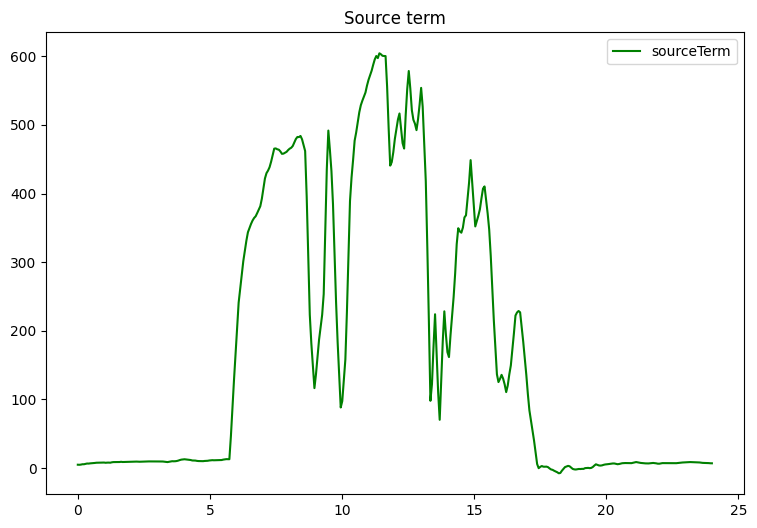

In [17]:
colnames_weather = ['datetime', 'wind_speed', 'wind_direction', 'humidity', 'air_temperature', 'air_pressure', 'solar_DNI']
url2 = "https://raw.githubusercontent.com/yajuna/linearRegression/master/Weather_Station_AUG21_to_AUG28_2022.xlsx"
dataWeather = pandas.read_excel(url2,names=colnames_weather)

#### training
# wind speed from Oct 21
train_windSpeed = np.array(dataWeather.wind_speed[:train_weather_index])
# humidity from Oct 21
train_humidity = np.array(dataWeather.humidity[:train_weather_index])
# air temperature from Oct 21
train_airTemp = np.array(dataWeather.air_temperature[:train_weather_index])+ 273.15
# air pressure from Oct 21
train_airPressure = np.array(dataWeather.air_pressure[:train_weather_index])
# solar radiation from Oct 21
train_solar = np.array(dataWeather.solar_DNI[:train_weather_index])

train_airTemp = np.interp(np.linspace(0,24,N_b), np.linspace(0,24,train_interp_weather_size),train_airTemp)
train_windSpeed = np.interp(np.linspace(0,24,N_b), np.linspace(0,24,train_interp_weather_size),train_windSpeed)
train_solar = np.interp(np.linspace(0,24,N_b), np.linspace(0,24,train_interp_weather_size),train_solar)


nu = 15.89e-6 # m^2/s kinematic viscosity of air
Pr = 0.707
ka = 26.3e-3 # W/mK conductivity of air
coeff = 2 * xmax / nu
Re = train_windSpeed * coeff
C = []
m = []
for j in range(train_windSpeed.size):
    temp = Re[j]
    if temp < 0.4:
        temp1 = [0, 0]
    if 0.4<=temp<= 4:
        temp1 = [0.989, 0.330]
    if 4<temp<= 40:
        temp1 = [0.911, 0.385]
    if 40<temp<= 4e3:
        temp1 = [0.683, 0.466]
    if 4e3<temp<= 4e4:
        temp1 = [0.193, 0.618]
    if 4e4<temp<= 4e5:
        temp1 = [0.027, 0.805]
    C.append(temp1[0])
    m.append(temp1[1])

Nu = C * Re ** m * Pr ** (1/3)
h = Nu * ka / (2 * xmax)

convect = h * (u_ub - train_airTemp)
sourceTerm = (1 - albedo) * train_solar + sigma * (train_airTemp**4 - u_ub**4) + convect
# coeffSource = (tmax - tmin)/N_b / (2 * xmax/N_b)
# s = coeffSource * sourceTerm

s = sourceTerm

# visualize sourceTerm to compare with cell_test
fig137 = plt.figure(figsize=(9,6))
plt.plot(t_b, sourceTerm, color='green', label='sourceTerm')

plt.legend()
plt.title("Source term")

Text(0.5, 1.0, 'Boundary temperature at the core')

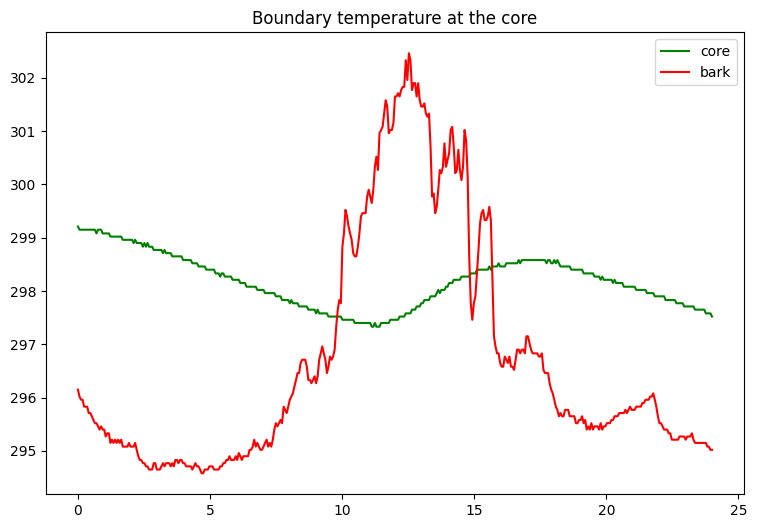

In [6]:
# visualize the boundary conditions.
fig1 = plt.figure(figsize=(9,6))
plt.plot(t_b, u_lb, color='green', label='core')
plt.plot(t_b, u_ub, color='red', label='bark')
plt.legend()
plt.title("Boundary temperature at the core")

Text(0.5, 1.0, 'Initial temperature distribution in tree trunk')

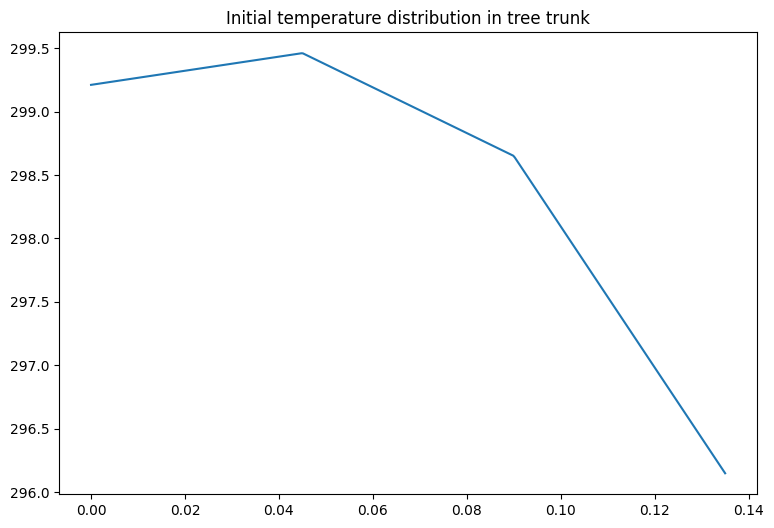

In [7]:
# visualize the initial condition.
fig2 = plt.figure(figsize=(9,6))
plt.plot(x_0, u_0, label = 'initial temp')
plt.legend
plt.title("Initial temperature distribution in tree trunk")

Plot initial and boundary data, and collocation data in time space.

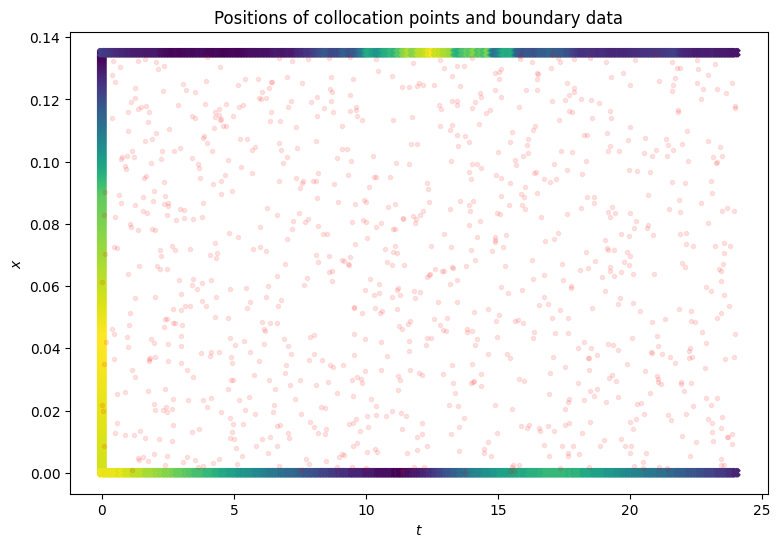

In [8]:
fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=u_0.min(), vmax=u_0.max())
plt.scatter(t_b, x_lb, c=u_lb, marker='X', vmin=u_lb.min(), vmax=u_lb.max())
plt.scatter(t_b, x_ub, c=u_ub, marker='X', vmin=u_ub.min(), vmax=u_ub.max())
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');
#plt.savefig('Xdata_heat.pdf', bbox_inches='tight', dpi=300)

Class implementation of PINN. Derive `PINN_NeuralNet` from `tf.keras.Model`.

Required arguments are the lower bound `lb` and upper bound `ub`. This is a general neural net that is equation independent.

In [9]:
# Define model architecture

class PINN_NeuralNet(tf.keras.Model):
  """Basic architecture of the PINN model
  """

  def __init__(self, lb, ub,
               output_dim = 1,
               num_hidden_layers = 8,
               num_neurons_per_layer = 20,
               activation = 'tanh',
               kernel_initializer = 'glorot_normal',
               **kwargs):
    super().__init__(**kwargs)

    self.num_hidden_layers = num_hidden_layers
    self.output_dim = output_dim
    self.lb = lb
    self.ub = ub

    # Define NN architecture
    self.scale = tf.keras.layers.Lambda(
            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers)]
    self.out = tf.keras.layers.Dense(output_dim)

  def call(self, X):
    """
    Forward-pass thru NN
    """
    Z = self.scale(X)
    for i in range(self.num_hidden_layers):
      Z = self.hidden[i](Z)
    return self.out(Z)

Derive from the above neural net class to take in additional parameters `lambd1`, `lambd2`, `lambd3`.

In [10]:
class PINNIdentificationNet(PINN_NeuralNet):
    def __init__(self, *args, **kwargs):

        # Call init of base class
        super().__init__(*args,**kwargs)

        # Initialize variable for lambda
        # initial guess: lambd1 = 0.16 / (720 * 1300), lambd2 = 1.0 / (720 * 1300)
        # use value after 6400 steps of training
        # It 06400: loss = 7.85567093e+00 lambda1 = 6.51998147e-02 lambda2 = -1.95997432e-36
        self.lambd1 = tf.Variable(0.3/(1.38 * 510), trainable=True, dtype=DTYPE)
        self.lambd1_list = []

        self.lambd2 = tf.Variable(1./(1.38 * 510), trainable=True, dtype=DTYPE)
        self.lambd2_list = []

Define base class `PINNSolver`. This is equation dependent. Components to customize are

1. get_r <---- modify what derivatives are computed
2. loss_fn <--- modify the boundary conditions
3. fun_r <--- residual of the PDE
4. should check all functions if boundary data were changed

Here we only consider the method based on tensorflow optimizer object as input. The [original notebook](https://colab.research.google.com/github/janblechschmidt/PDEsByNNs/blob/main/PINN_Solver.ipynb#scrollTo=wcOkamgfZEks) though, also has method based on SciPy's LBFGS method.

In [11]:
class PINNSolver():
    def __init__(self, model, X_r):
        self.model = model

        # Store collocation points, separate t and x
        self.t = X_r[:,0:1]
        self.x = X_r[:,1:2]

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0

    def get_r(self):

        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.t)
            tape.watch(self.x)

            # Compute current values u(t,x)
            u = self.model(tf.stack([self.t[:,0], self.x[:,0]], axis=1))

            u_x = tape.gradient(u, self.x)

        u_t = tape.gradient(u, self.t)
        u_xx = tape.gradient(u_x, self.x)

        del tape

        return self.fun_r(self.t, self.x, u, u_t, u_x, u_xx) ########


    def loss_fn(self, X, u):

        # Compute phi_r
        r = self.get_r()
        phi_r = tf.reduce_mean(tf.square(r))

        # Initialize loss
        loss = phi_r

        # Add phi_0 and phi_b to the loss
        for i in range(len(X)):
            u_pred = self.model(X[i])
            loss += tf.reduce_mean(tf.square(u[i] - u_pred))

        return loss


    def get_grad(self, X, u):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn(X, u)

        g = tape.gradient(loss, self.model.trainable_variables)
        del tape

        return loss, g


    def fun_r(self, t, x, u, u_t, u_x, u_xx):
        """Residual of the PDE"""
        return u_t - self.model.lambd1 * 1./ x * u_x - self.model.lambd1 * u_xx - self.model.lambd2 * s

    def solve_with_TFoptimizer(self, optimizer, X, u, N=1001):
        """This method performs a gradient descent type optimization."""

        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(X, u)

            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss

        for i in range(N):

            loss = train_step()

            self.current_loss = loss.numpy()
            self.callback()

    def callback(self, xr=None):
        lambd1 = self.model.lambd1.numpy()
        self.model.lambd1_list.append(lambd1)

        lambd2 = self.model.lambd2.numpy()
        self.model.lambd2_list.append(lambd2)

        if self.iter % 100 == 0:
            print('It {:05d}: loss = {:10.8e} lambda1 = {:10.8e} lambda2 = {:10.8e}'.format(self.iter, self.current_loss, lambd1, lambd2))

        self.hist.append(self.current_loss)
        self.iter += 1


    def plot_solution(self, **kwargs):
        N = 411
        tspace = np.linspace(self.model.lb[0], self.model.ub[0], N)
        xspace = np.linspace(self.model.lb[1], self.model.ub[1], N)
        T, X = np.meshgrid(tspace, xspace)
        Xgrid = np.vstack([T.flatten(),X.flatten()]).T
        upred = self.model(tf.cast(Xgrid,DTYPE))
        U = upred.numpy().reshape(N,N)
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(T, X, U, cmap='viridis', **kwargs)
        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        ax.set_zlabel('$u_\\theta(t,x)$')
        ax.view_init(35,35)
        return ax

    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

    def plot_loss_and_param(self, axs=None):
        if axs:
            ax1, ax2 = axs
            self.plot_loss_history(ax1)
        else:
            ax1 = self.plot_loss_history()
            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        # color = 'tab:blue'
        ax2.tick_params(axis='y', labelcolor='tab:blue')
        ax2.plot(range(len(self.hist)), self.model.lambd1_list,'-',color='tab:blue')
        ax2.plot(range(len(self.hist)), self.model.lambd2_list,'-',color='tab:red')
        ax2.set_ylabel('$\\lambda^{n_{epoch}}$', color='tab:blue')
        return (ax1,ax2)

Initialize model and solver.

In [12]:
# initialize model
model = PINNIdentificationNet(lb, ub, num_hidden_layers=2)
model.build(input_shape=(None,2))

# initialize PINN solver
solver = PINNSolver(model, X_r)

Start training

In [ ]:
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
optim = tf.keras.optimizers.Adam(learning_rate=lr)

# start timer
t0 = time()

solver.solve_with_TFoptimizer(optim, X_data, u_data, N=EPOCH)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

Plot solution and loss history

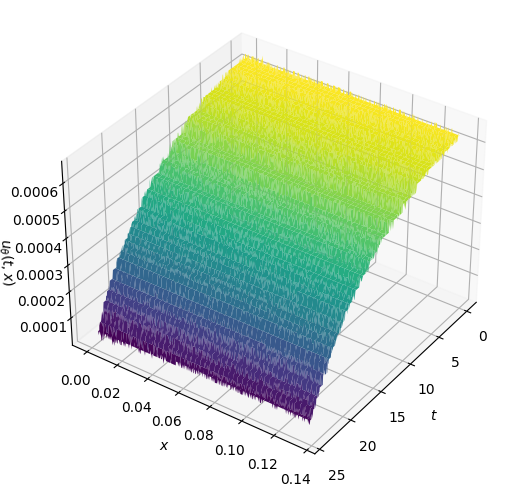

In [14]:
solver.plot_solution();


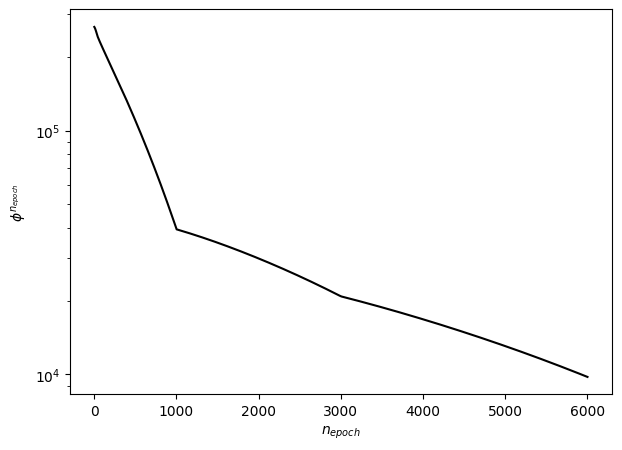

In [15]:

solver.plot_loss_history();


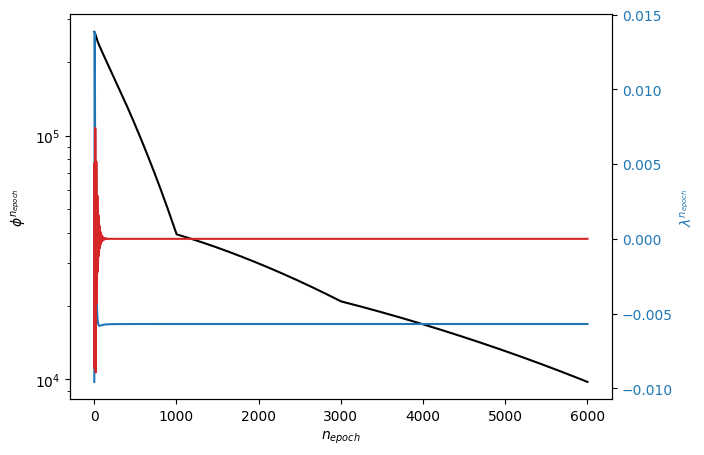

In [16]:

solver.plot_loss_and_param();

# Cells below replace cells after "Class implementation of PINN..."

## As of now, the error in computation seems more like coding error (1e5) rather than logic error (expected 1e0), so we work on the following methods to debug

Write a simplified forward problem; eliminate parameter identification problem, and use $\lambda_1$ and $\lambda_2$ that worked for FD problem in cell_test. These values should be

$\lambda_1=k/\rho c=0.3/(1.38 * 510)$ and $\lambda_2=1/\rho c=0.3/(1.38 * 510)$. We will see if the errors are still very big.

The code below is modified from

https://github.com/yajuna/tensorflow_pde/blob/master/Simple_PDE_with_tensorflow.ipynb


In [19]:
lambd1 = 0.3/(1.38 * 510)
lambd2 = 1./(1.38 * 510)

In [18]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))

    return model


In [20]:
def get_r(model, X_r)-> tf.Tensor:

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)

        # Determine residual
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)
        u_t = tape.gradient(u, t)

    u_xx = tape.gradient(u_x, x)

    del tape

    return u_t - 1./x * lambd1 * u_x - lambd1 * u_xx - lambd2 * sourceTerm

In [21]:
model = init_model(num_hidden_layers = 2)
r = get_r(model, X_0)
phi_r = tf.reduce_mean(tf.square(r))
loss = phi_r

print(X_0.shape)
print(X_0[1].shape)


(411, 2)
(2,)


In [22]:
def compute_loss(model, X_r, X_0, X_lb, X_ub, u_0)-> tf.Tensor:

    # Compute phi^r-- physics informed loss
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))

    # Initialize loss
    loss = phi_r

    # Add initial error loss
    u_pred = model(X_0)
    loss += tf.reduce_mean(tf.square(u_0 - u_pred))



    # add boundary error in the loss compute the boundary difference.

    ul_pred = model(X_lb)
    uu_pred = model(X_ub)
    loss += tf.reduce_mean(tf.square(ul_pred - uu_pred))

    return loss

In [23]:
loss = compute_loss(model, X_r, X_0, X_lb, X_ub, u_0)

In [24]:
def get_grad(model, X_r, X_0, X_lb, X_ub, u_0):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_0, X_lb, X_ub, u_0)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [25]:
# Initialize model aka u_\theta
model = init_model(num_hidden_layers = 2)
# print(model.layers[0].input_shape)

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [ ]:
# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step()-> tf.Tensor:
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_0, X_lb, X_ub, u_0)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

# Number of training epochs
EPOCH = 500000
hist = []

# Start timer
t0 = time()

for i in range(EPOCH+1):

    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

Streaming output truncated to the last 5000 lines.
It 231850: loss = 1.00977612e+00
It 231900: loss = 1.00981057e+00
It 231950: loss = 1.00977623e+00
It 232000: loss = 1.00977647e+00
It 232050: loss = 1.00977790e+00
It 232100: loss = 1.00980079e+00
It 232150: loss = 1.00977600e+00
It 232200: loss = 1.00979805e+00
It 232250: loss = 1.00978851e+00
It 232300: loss = 1.00982404e+00
It 232350: loss = 1.00979948e+00
It 232400: loss = 1.00979233e+00
It 232450: loss = 1.00981355e+00
It 232500: loss = 1.00981259e+00
It 232550: loss = 1.00979280e+00
It 232600: loss = 1.00984466e+00
It 232650: loss = 1.00980949e+00
It 232700: loss = 1.00977647e+00
It 232750: loss = 1.00977588e+00
It 232800: loss = 1.01016498e+00
It 232850: loss = 1.00977647e+00
It 232900: loss = 1.00977576e+00
It 232950: loss = 1.00983906e+00
It 233000: loss = 1.00977743e+00
It 233050: loss = 1.00977683e+00
It 233100: loss = 1.00979137e+00
It 233150: loss = 1.00977576e+00
It 233200: loss = 1.00980306e+00
It 233250: loss = 1.00978

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = model(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis');
ax.view_init(40,40)
ax.set_xlabel('
')
ax.set_ylabel('
')
ax.set_zlabel('
')
ax.set_title('Solution of wave equation');
#plt.savefig('wave_Solution.pdf', bbox_inches='tight', dpi=300);


In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('
')
ax.set_ylabel('
');
